# Vision Transformer (ViT), Convolutional Neural Network (CNN) and Compact Convolutional Transformer (CCT)

### Connect to Colab

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
%cd /gdrive/Google Colab/Tranformers/02 - Vision Transformers

[Errno 2] No such file or directory: '/gdrive/Google Colab/Tranformers/02 - Vision Transformers'
/content


### Import libraries

In [4]:
import tensorflow as tf
import numpy as np
import os
import shutil
import random
import glob
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


### Set seed for reproducibility

In [5]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [6]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### Load and process data

In [7]:
num_classes = 100
input_shape = (32, 32, 3)

(X_train, y_train), (X_test, y_test) = tfk.datasets.cifar100.load_data()

print(f"x_train shape: {X_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {X_test.shape} - y_test shape: {y_test.shape}")

169001437/169001437 [==============================] - 20s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


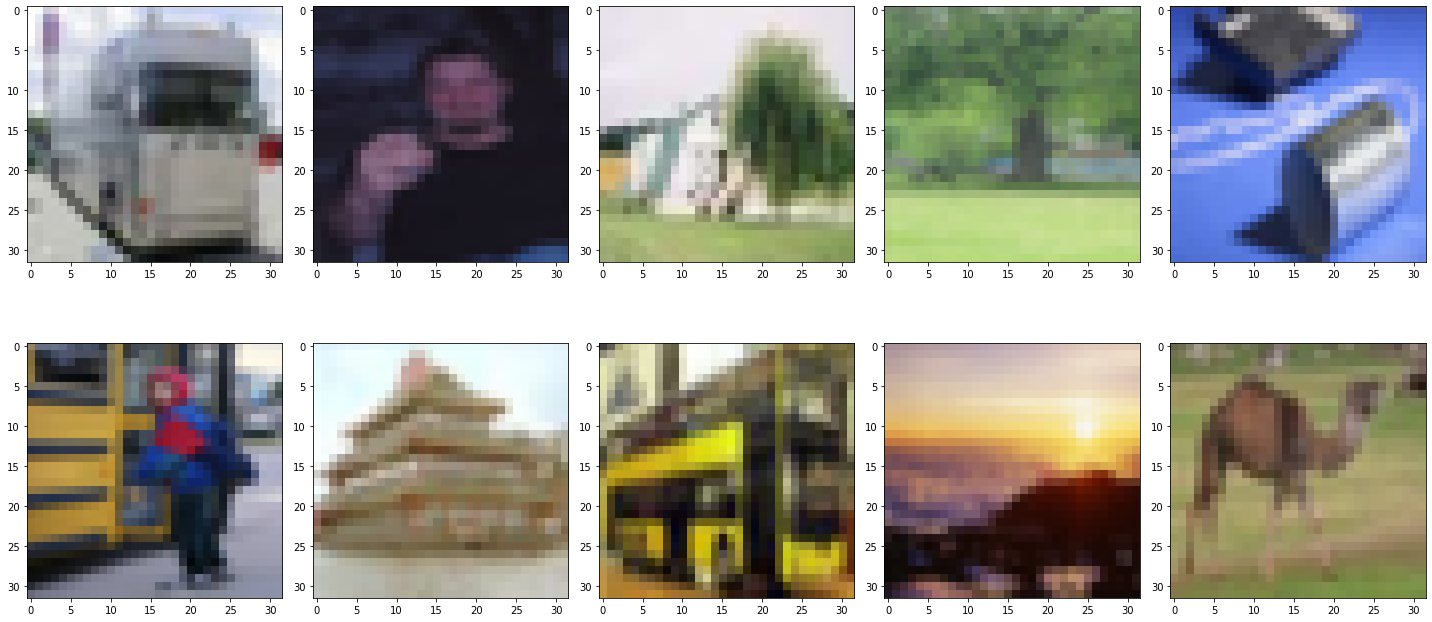

In [8]:
# Inspect the data
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(10*num_row,2*num_col))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(X_train[np.random.choice(range(X_train.shape[0]))])
plt.tight_layout()
plt.show()

### Visual Transformer (ViT)

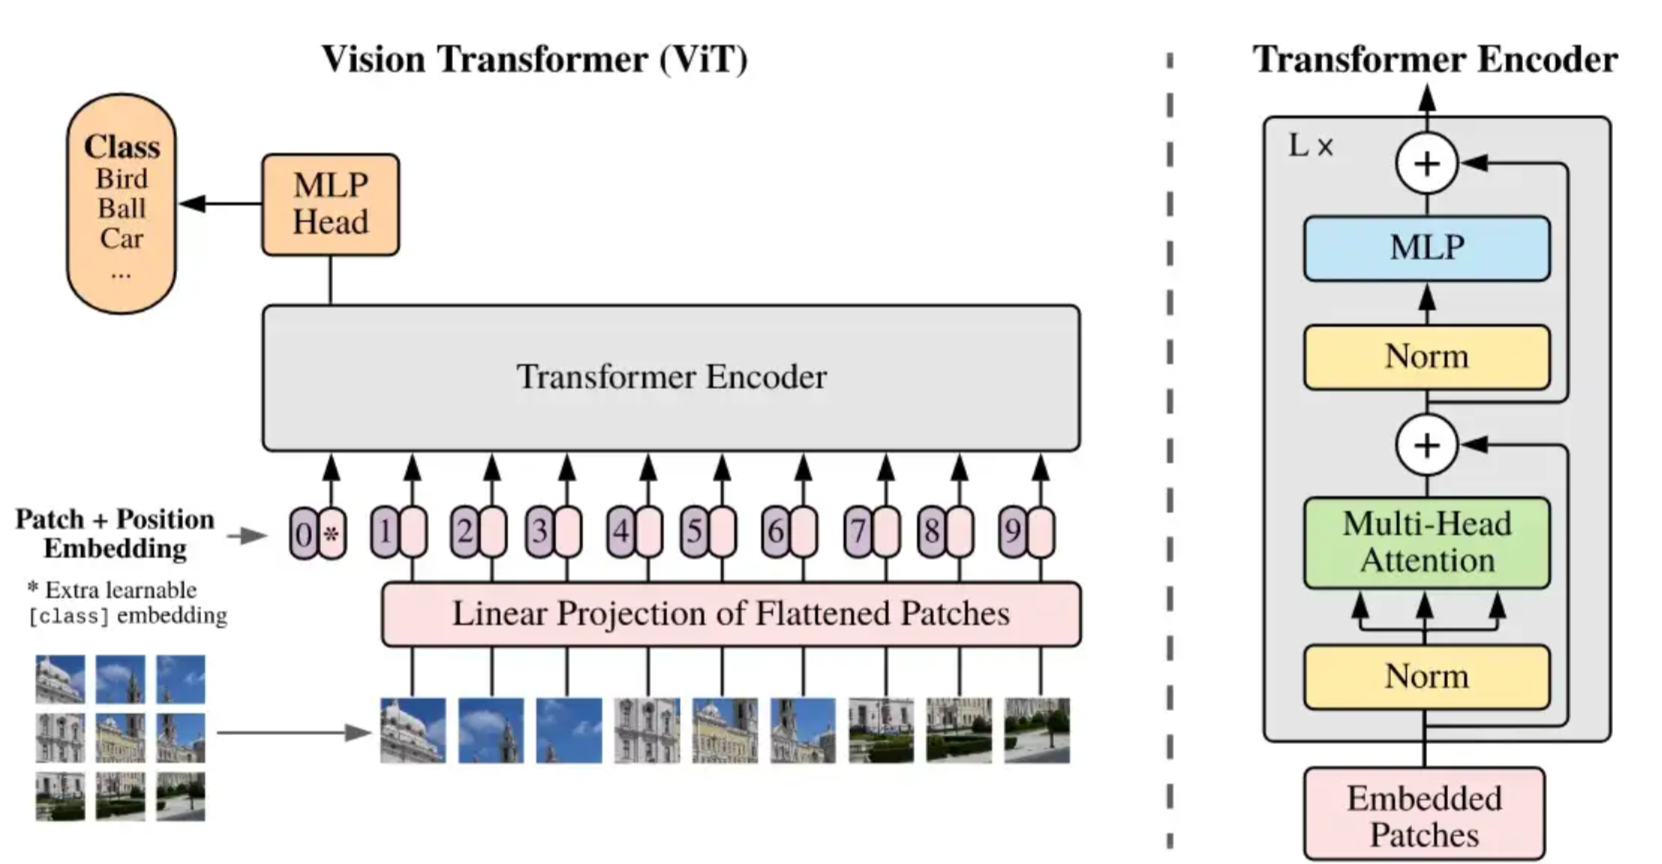

In [9]:
# We'll resize input images to this size
image_size = 72 
# Size of the patches to be extract from the input images
patch_size = 6  
num_patches = (image_size // patch_size) ** 2
print(image_size,patch_size,num_patches)

72 6 144


In [10]:
# This code creates a data augmentation pipeline using the TensorFlow Keras (tfk) library. 
# The pipeline consists of two steps: normalization and resizing.

data_augmentation = tfk.Sequential(
    [
        tfkl.Normalization(),
        tfkl.Resizing(image_size, image_size)
    ],
    name="data_augmentation",
)

# The first step in the pipeline is normalization, which is implemented using the Normalization layer 
# from the TensorFlow Keras Layers (tfkl) library.
# This normalization step is used to standardize the input data by subtracting the mean 
# and dividing by the standard deviation.

# The second step in the pipeline is resizing, which is implemented using the Resizing layer 
# from the TensorFlow Keras Layers (tfkl) library.
# This resizing step is used to resize the image to a specific size (image_size, image_size)

# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

In [17]:
class Patches(tfkl.Layer):
    # Custom Layer to extract patches from images
    # patch_size: size of the patches to be extracted
    def init(self, patch_size, **kwargs):
        # Initialize the layer
        super().init(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        # Extract patches from images
        # images: 4D tensor of shape (batch_size, height, width, channels)
        batch_size = tf.shape(images)[0]
        
        # Extracts patches from the images tensor and returns a 4D tensor
        # shape (batch_size, num_patches, patch_height, patch_width, channels)
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        
        # Get patch dimension
        patch_dims = patches.shape[-1]
        
        # Reshape the patches to have shape (batch_size, num_patches, patch_height * patch_width * channels)
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

AttributeError: ignored

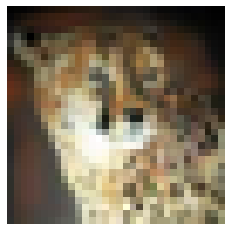

In [20]:
plt.figure(figsize=(4, 4))

# Randomly select an image from the training set
image = X_train[np.random.choice(range(X_train.shape[0]))]

# Plot the original image
plt.imshow(image.astype("uint8"))
plt.axis("off")

# Resize the image to the specified image size
resized_image = tf.image.resize(tf.convert_to_tensor([image]), size=(image_size, image_size))

# Extract patches from the resized image using the Patches layer
patches = Patches(patch_size)(resized_image)

# Print the image and patch size, number of patches per image, and number of elements per patch
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

# Plot the patches
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    # Reshape the patch to (patch_size, patch_size, 3)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
# Define the embedding dimention
projection_dim = 64

In [ ]:
class PatchEncoder(tfkl.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.projection = tfkl.Dense(units=projection_dim)
        self.position_embedding = tfkl.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch):
        # Project the patch into a lower-dimensional space
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        # Add position embedding to the encoded patch
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
def transformer_block(x, heads, key_dim, units, dropout_rate, name=''):

    # normalize the input
    x1 = tfkl.LayerNormalization(epsilon=1e-6)(x)
    # apply multi-head attention to the normalized input
    attention_output, attention_weights = tfkl.MultiHeadAttention(
        num_heads=heads, 
        key_dim=key_dim, 
        dropout=dropout_rate, 
        name=name+'att'
    )(x1, x1, return_attention_scores=True)
    # apply dropout to the attention output
    attention_output = tfkl.Dropout(dropout_rate)(attention_output)
    # add the attention output to the original input
    x2 = tfkl.Add()([attention_output, x1])
    # normalize the result of the addition
    x3 = tfkl.LayerNormalization(epsilon=1e-6)(x2)    
    # apply a dense layer with the gelu activation function
    x3 = tfkl.Dense(units, activation=tf.nn.gelu)(x3)
    # apply dropout to the dense layer output
    x3 = tfkl.Dropout(dropout_rate)(x3)
    # add the dense layer output to the result of the addition
    x3 = tfkl.Add()([x3, x2])

    return x3, attention_weights

In [ ]:
def get_visual_transformer(
    blocks, 
    heads, 
    key_dim, 
    units, 
    num_patches, 
    projection_dim, 
    dropout_rate=0.33
    ):
    
    inputs = tfkl.Input(shape=input_shape, name='inputs')
    # Augment data
    augmented = data_augmentation(inputs)
    # Create patches
    patches = Patches(patch_size)(augmented)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    
    for b in range(blocks):
        encoded_patches, attention_weights = transformer_block(
            encoded_patches, 
            heads, 
            key_dim, 
            units,
            dropout_rate,
            name='block'+str(b)+'_'
        )
    
    # Create a [batch_size, projection_dim] tensor
    representation = tfkl.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = tfkl.Flatten()(representation)
    representation = tfkl.Dropout(0.5)(representation)
    # Classify outputs
    logits = tfkl.Dense(num_classes)(representation)
    # Create the Keras model
    model = tfk.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
ViT = get_visual_transformer(
    blocks=4,
    heads=4,
    key_dim=projection_dim,
    units=projection_dim,
    projection_dim=projection_dim,
    num_patches=num_patches
)

In [ ]:
# Inspect model parameters
ViT.summary()

In [ ]:
# Inspect model structure
tfk.utils.plot_model(ViT)

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100

In [ ]:
optimizer = tfk.optimizers.experimental.AdamW(
    learning_rate=learning_rate, weight_decay=weight_decay
)

ViT.compile(
    optimizer=optimizer,
    loss=tfk.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        tfk.metrics.SparseCategoricalAccuracy(name="accuracy"),
        tfk.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

checkpoint_filepath = "/tmp/checkpointViT"
checkpoint_callback = tfk.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

reduce_lr = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=10,
    mode='max',
    min_lr=1e-5
)

ViT_history = ViT.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.1,
    callbacks=[
        checkpoint_callback,
        reduce_lr
    ]
)

ViT.load_weights(checkpoint_filepath)
_, accuracy, top_5_accuracy = ViT.evaluate(X_test, y_test, verbose=False)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(ViT_history.history['loss'], alpha=.2, color='#ff7f0e', linewidth=3)
plt.plot(ViT_history.history['val_loss'], label='ViT', alpha=.9, color='#ff7f0e', linewidth=3)
plt.legend(loc='upper right')
plt.title('Categorical Cross Entropy')
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(15,4))
plt.plot(ViT_history.history['accuracy'], alpha=.2, color='#ff7f0e', linewidth=3)
plt.plot(ViT_history.history['val_accuracy'], label='ViT', alpha=.9, color='#ff7f0e', linewidth=3)
plt.legend(loc='upper right')
plt.title('Top1 Accuracy')
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(15,4))
plt.plot(ViT_history.history['top-5-accuracy'], alpha=.2, color='#ff7f0e', linewidth=3)
plt.plot(ViT_history.history['val_top-5-accuracy'], label='ViT', alpha=.9, color='#ff7f0e', linewidth=3)
plt.legend(loc='upper right')
plt.title('Top5 Accuracy')
plt.grid(alpha=.3)
plt.show()

Convolutional Neural Network (CNN)

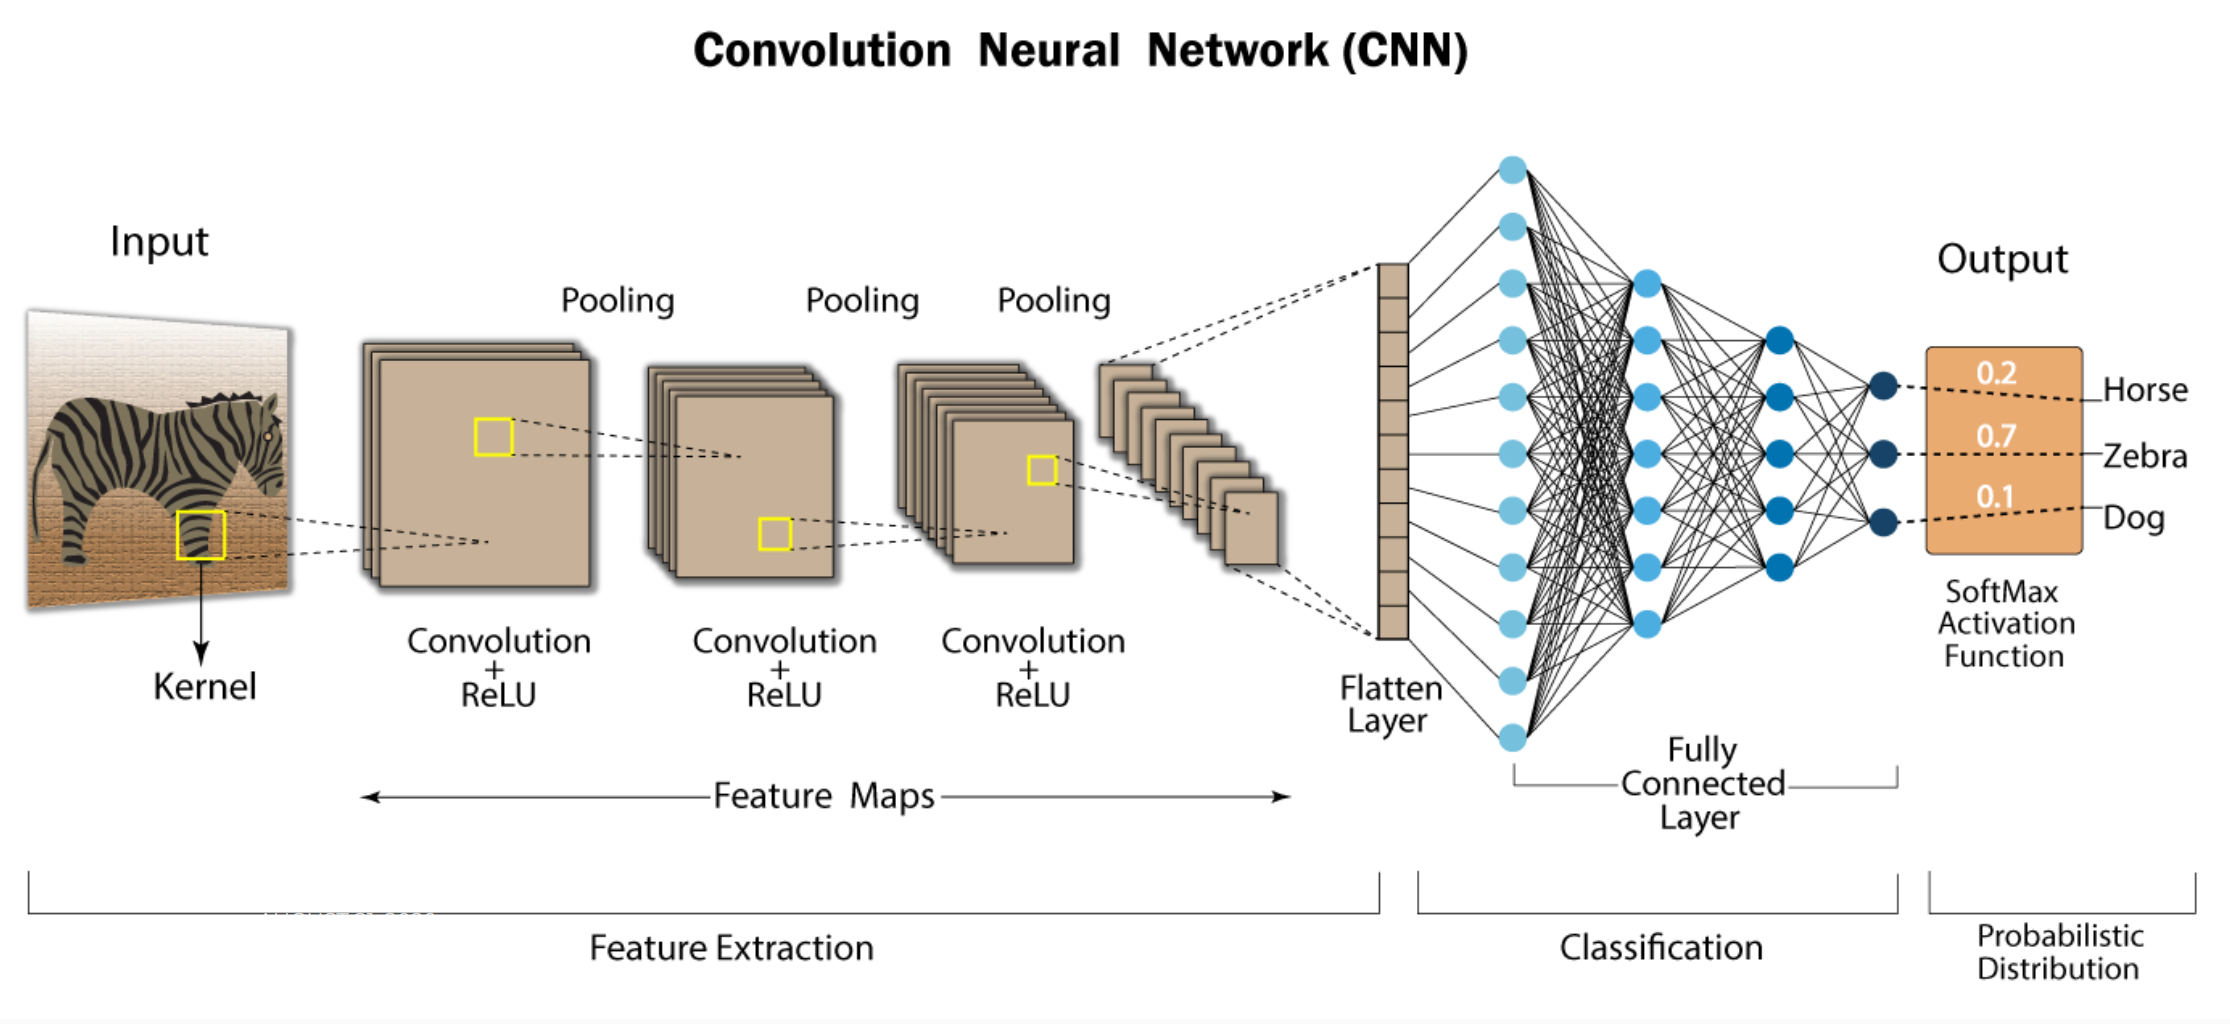

In [ ]:
def convolutional_block(x, filters, kernel):
    # Apply convolution operation to the input x
    x = tfkl.Conv2D(
        filters, 
        kernel,
        strides=1,
        padding='same',
        activation='relu'
    )(x)
    # Apply max pooling operation to the convolution output
    x = tfkl.MaxPooling2D()(x)
    
    return x

In [ ]:
def get_convolutional_neural_network(
    blocks, 
    filters, 
    kernel
    ):
    
    inputs = tfkl.Input(shape=input_shape, name='inputs')
    # Augment data
    x = data_augmentation(inputs)
    # Extract features via convolution and pooling operations
    for b in range(blocks):
        x = convolutional_block(x, filters*(b+1), kernel)
    x = tfkl.Flatten()(x)
    x = tfkl.Dropout(0.5)(x)
    # Classify outputs
    logits = tfkl.Dense(num_classes)(x)
    # Create the Keras model
    model = tfk.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
CNN = get_convolutional_neural_network(
    blocks = 2,
    filters = 64,
    kernel = 5
)

In [ ]:
# Inspect model parameters
CNN.summary()

In [ ]:
# Inspect model structure
tfk.utils.plot_model(CNN)

In [ ]:
optimizer = tfk.optimizers.experimental.AdamW(
    learning_rate=learning_rate, weight_decay=weight_decay
)

CNN.compile(
    optimizer=optimizer,
    loss=tfk.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        tfk.metrics.SparseCategoricalAccuracy(name="accuracy"),
        tfk.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

checkpoint_filepath = "/tmp/checkpointCNN"
checkpoint_callback = tfk.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

reduce_lr = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=10,
    mode='max',
    min_lr=1e-5
)

CNN_history = CNN.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.1,
    callbacks=[
        checkpoint_callback,
        reduce_lr
    ]
)

CNN.load_weights(checkpoint_filepath)
_, accuracy, top_5_accuracy = CNN.evaluate(X_test, y_test, verbose=False)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(ViT_history.history['loss'], alpha=.2, color='#ff7f0e', linewidth=3)
plt.plot(ViT_history.history['val_loss'], label='ViT', alpha=.9, color='#ff7f0e', linewidth=3)
plt.plot(CNN_history.history['loss'], alpha=.2, color='#4D61E2', linewidth=3)
plt.plot(CNN_history.history['val_loss'], label='CNN', alpha=.9, color='#4D61E2', linewidth=3)
plt.legend(loc='upper right')
plt.title('Categorical Cross Entropy')
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(15,4))
plt.plot(ViT_history.history['accuracy'], alpha=.2, color='#ff7f0e', linewidth=3)
plt.plot(ViT_history.history['val_accuracy'], label='ViT', alpha=.9, color='#ff7f0e', linewidth=3)
plt.plot(CNN_history.history['accuracy'], alpha=.2, color='#4D61E2', linewidth=3)
plt.plot(CNN_history.history['val_accuracy'], label='CNN', alpha=.9, color='#4D61E2', linewidth=3)
plt.legend(loc='upper right')
plt.title('Top1 Accuracy')
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(15,4))
plt.plot(ViT_history.history['top-5-accuracy'], alpha=.2, color='#ff7f0e', linewidth=3)
plt.plot(ViT_history.history['val_top-5-accuracy'], label='ViT', alpha=.9, color='#ff7f0e', linewidth=3)
plt.plot(CNN_history.history['top-5-accuracy'], alpha=.2, color='#4D61E2', linewidth=3)
plt.plot(CNN_history.history['val_top-5-accuracy'], label='CNN', alpha=.9, color='#4D61E2', linewidth=3)
plt.legend(loc='upper right')
plt.title('Top5 Accuracy')
plt.grid(alpha=.3)
plt.show()

### Compact Convolutional Transformet (CCT)

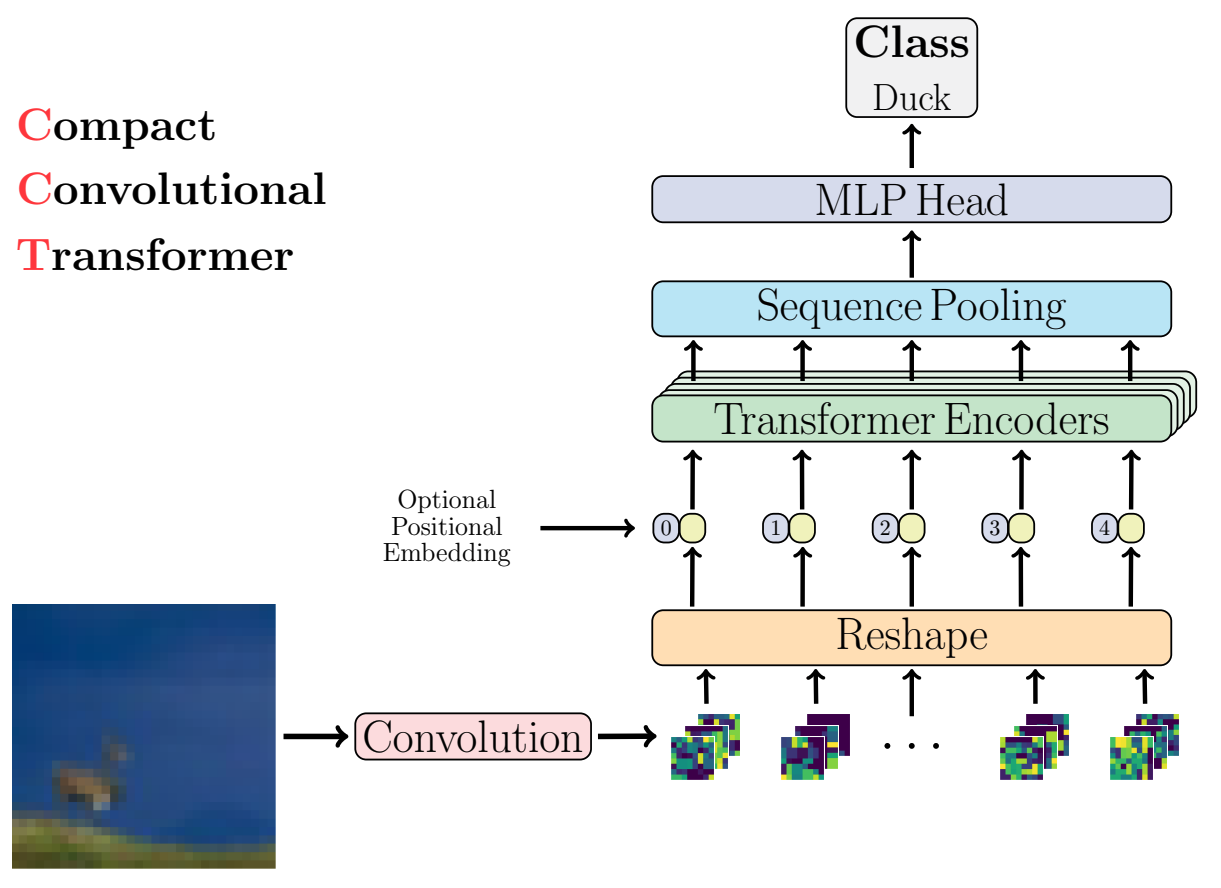

In [ ]:
class CCTTokenizer(tfkl.Layer):
    def __init__(
        self,
        blocks,
        filters,
        kernel,
        positional_emb=True,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # This is our tokenizer.
        self.cnn = tfk.Sequential()
        for i in range(blocks):
            self.cnn.add(
                tfkl.Conv2D(
                    filters*(i+1),
                    kernel,
                    strides=1,
                    padding="same",
                    activation="relu",
                )
            )
            self.cnn.add(tfkl.MaxPool2D())
        self.positional_emb = positional_emb

    def call(self, images):
        outputs = self.cnn(images)
        # After passing the images through our mini-network the spatial dimensions
        # are flattened to form sequences.
        reshaped = tf.reshape(
            outputs,
            (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[-1]),
        )
        return reshaped

    def positional_embedding(self, image_size):
        # Positional embeddings are optional in CCT. Here, we calculate
        # the number of sequences and initialize an `Embedding` layer to
        # compute the positional embeddings later.
        if self.positional_emb:
            dummy_inputs = tf.ones((1, image_size, image_size, 3))
            dummy_outputs = self.call(dummy_inputs)
            sequence_length = tf.shape(dummy_outputs)[1]
            projection_dim = tf.shape(dummy_outputs)[-1]

            embed_layer = tfkl.Embedding(input_dim=sequence_length, output_dim=projection_dim)
            return embed_layer, sequence_length
        else:
            return None

In [ ]:
def get_compact_convolutional_transformer(
    cnn_blocks,
    filters,
    kernel,
    att_blocks,
    heads, 
    key_dim, 
    units, 
    num_patches, 
    projection_dim, 
    dropout_rate=0.33,
    positional_emb=True
):
    
    inputs = tfkl.Input(input_shape)

    # Augment data.
    augmented = data_augmentation(inputs)

    # Encode patches.
    cct_tokenizer = CCTTokenizer(cnn_blocks,filters,kernel)
    encoded_patches = cct_tokenizer(augmented)

    # Apply positional embedding.
    if positional_emb:
        pos_embed, seq_length = cct_tokenizer.positional_embedding(image_size)
        positions = tf.range(start=0, limit=seq_length, delta=1)
        position_embeddings = pos_embed(positions)
        encoded_patches += position_embeddings
        
    
    for b in range(att_blocks):
        encoded_patches, attention_weights = transformer_block(
            encoded_patches, 
            heads, 
            key_dim, 
            units,
            dropout_rate,
            name='block'+str(b)+'_'
        )
        
    # Create a [batch_size, projection_dim] tensor.
    representation = tfkl.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = tfkl.Flatten()(representation)
    representation = tfkl.Dropout(0.5)(representation)
    # Classify outputs.
    logits = tfkl.Dense(num_classes)(representation)
    # Create the Keras model.
    model = tfk.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
CCT = get_compact_convolutional_transformer(
    cnn_blocks=2,
    filters = 64,
    kernel = 5,
    att_blocks=4,
    heads=4,
    key_dim=projection_dim,
    units=128,
    projection_dim=projection_dim,
    num_patches=num_patches
)

In [ ]:
# Inspect model parameters
CCT.summary()

In [ ]:
# Inspect model structure
tfk.utils.plot_model(CCT)

In [ ]:
optimizer = tfk.optimizers.experimental.AdamW(
    learning_rate=learning_rate, weight_decay=weight_decay
)

CCT.compile(
    optimizer=optimizer,
    loss=tfk.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        tfk.metrics.SparseCategoricalAccuracy(name="accuracy"),
        tfk.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

checkpoint_filepath = "/tmp/checkpointCCT"
checkpoint_callback = tfk.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

reduce_lr = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=10,
    mode='max',
    min_lr=1e-5
)

CCT_history = CCT.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.1,
    callbacks=[
        checkpoint_callback,
        reduce_lr
    ]
)

CCT.load_weights(checkpoint_filepath)
_, accuracy, top_5_accuracy = CCT.evaluate(X_test, y_test, verbose=False)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(ViT_history.history['loss'], alpha=.2, color='#ff7f0e', linewidth=3)
plt.plot(ViT_history.history['val_loss'], label='ViT', alpha=.9, color='#ff7f0e', linewidth=3)
plt.plot(CNN_history.history['loss'], alpha=.2, color='#4D61E2', linewidth=3)
plt.plot(CNN_history.history['val_loss'], label='CNN', alpha=.9, color='#4D61E2', linewidth=3)
plt.plot(CCT_history.history['loss'], alpha=.2, color='#009900', linewidth=3)
plt.plot(CCT_history.history['val_loss'], label='CCT', alpha=.9, color='#009900', linewidth=3)
plt.legend(loc='upper right')
plt.title('Categorical Cross Entropy')
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(15,4))
plt.plot(ViT_history.history['accuracy'], alpha=.2, color='#ff7f0e', linewidth=3)
plt.plot(ViT_history.history['val_accuracy'], label='ViT', alpha=.9, color='#ff7f0e', linewidth=3)
plt.plot(CNN_history.history['accuracy'], alpha=.2, color='#4D61E2', linewidth=3)
plt.plot(CNN_history.history['val_accuracy'], label='CNN', alpha=.9, color='#4D61E2', linewidth=3)
plt.plot(CCT_history.history['accuracy'], alpha=.2, color='#009900', linewidth=3)
plt.plot(CCT_history.history['val_accuracy'], label='CCT', alpha=.9, color='#009900', linewidth=3)
plt.legend(loc='upper right')
plt.title('Top1 Accuracy')
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(15,4))
plt.plot(ViT_history.history['top-5-accuracy'], alpha=.2, color='#ff7f0e', linewidth=3)
plt.plot(ViT_history.history['val_top-5-accuracy'], label='ViT', alpha=.9, color='#ff7f0e', linewidth=3)
plt.plot(CNN_history.history['top-5-accuracy'], alpha=.2, color='#4D61E2', linewidth=3)
plt.plot(CNN_history.history['val_top-5-accuracy'], label='CNN', alpha=.9, color='#4D61E2', linewidth=3)
plt.plot(CCT_history.history['top-5-accuracy'], alpha=.2, color='#009900', linewidth=3)
plt.plot(CCT_history.history['val_top-5-accuracy'], label='CCT', alpha=.9, color='#009900', linewidth=3)
plt.legend(loc='upper right')
plt.title('Top5 Accuracy')
plt.grid(alpha=.3)
plt.show()